In [ ]:
!pip install -q av
# !pip uninstall transformers
!pip install git+https://github.com/huggingface/transformers
# !pip install -q flash-attn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 23.7 MB/s eta 0:00:00
  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-800bq69h
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-800bq69h
  Resolved https://github.com/huggingface/transformers to commit 1d063793318b20654ebb850f48f43e0a247ab7bb
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 36.4 MB/s eta 0:00:00
  Created wheel for transformers: filename=transformers-4.47.0.dev0-py3-none-any.whl size=10036538 sha256=f8c5cda914b9e198975a1d0923416795f1c0ba9cfe880b05098872f09be348f5
  Stored in directory: /tmp/pip-ephem-wheel-cache-bnpqg19y/wheels/c0/14/d6/6c9a5582d2ac191ec0a483be151a4495fe1eb2a6706ca49f1b
Successfully built transformers
  Attempting uninstall: tokenizers
    Found existing installa

In [ ]:
import av
import numpy as np
from huggingface_hub import hf_hub_download

import torch
from transformers import AutoProcessor, LlavaOnevisionForConditionalGeneration

import torch
import cv2
import numpy as np
from PIL import Image
import requests
import copy
import warnings
from tqdm.notebook import tqdm
import os
import json
from collections import defaultdict

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
# Load the model in half-precision
model_name = 'llava-hf/llava-onevision-qwen2-0.5b-ov-hf'

model = LlavaOnevisionForConditionalGeneration.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map="auto",
    low_cpu_mem_usage=True,
    attn_implementation="sdpa",
)

processor = AutoProcessor.from_pretrained(model_name)

config.json:   0%|          | 0.00/2.59k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.79G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/126 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/178 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/826 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/1.73k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.80k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/367 [00:00<?, ?B/s]

video_processor/preprocessor_config.json:   0%|          | 0.00/428 [00:00<?, ?B/s]

In [ ]:
model.config.vocab_size = model.config.text_config.vocab_size

In [ ]:
# For videos we have to feed a "video" type instead of "image"
conversation = [
    {

        "role": "user",
        "content": [
            {"type": "video"},
            {"type": "text", "text": "What is shown in this video?"},
            ],
    },
]

prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)

In [ ]:
prompt

'<|im_start|>user <video>\nWhat is shown in this video?<|im_end|><|im_start|>assistant\n'

In [ ]:
def read_video_pyav(container, indices):
    '''
    Decode the video with PyAV decoder.
    Args:
        container (`av.container.input.InputContainer`): PyAV container.
        indices (`List[int]`): List of frame indices to decode.
    Returns:
        result (np.ndarray): np array of decoded frames of shape (num_frames, height, width, 3).
    '''
    frames = []
    container.seek(0)
    start_index = indices[0]
    end_index = indices[-1]
    for i, frame in enumerate(container.decode(video=0)):
        if i > end_index:
            break
        if i >= start_index and i in indices:
            frames.append(frame)
    return np.stack([x.to_ndarray(format="rgb24") for x in frames])


## for one video

In [ ]:
# Load the video as an np.array, sampling uniformly 8 frames (can sample more for longer videos, up to 32 frames)
video_path = hf_hub_download(repo_id="raushan-testing-hf/videos-test", filename="sample_demo_1.mp4", repo_type="dataset")
# video_path = "/content/5c0a032c998cfe00a955d220_сын унижает и оскорбляет мать как повлиять.mp4"
container = av.open(video_path)
total_frames = container.streams.video[0].frames
indices = np.arange(0, total_frames, total_frames / 8).astype(int)
# indices = np.arange(0, total_frames).astype(int)
video = read_video_pyav(container, indices)

sample_demo_1.mp4:   0%|          | 0.00/1.55M [00:00<?, ?B/s]

In [ ]:
video.shape

(8, 360, 640, 3)

In [ ]:
inputs = processor(videos=list(video), text=prompt, return_tensors="pt").to("cuda:0", torch.float16)

out = model.generate(**inputs,
            do_sample=False,
            temperature=0.5,
            max_new_tokens=4096,
            return_dict_in_generate=True,
            # output_logits=True,
            output_scores=True
                     )

out.keys()

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)
From v4.47 onwards, when a model cache is to be returned, `generate` will return a `Cache` instance instead by default (as opposed to the legacy tuple of tuples format). If you want to keep returning the legacy format, please set `return_legacy_cache=True`.


odict_keys(['sequences', 'scores', 'past_key_values'])

In [ ]:
model.config.vocab_size = model.config.text_config.vocab_size

In [ ]:
transition_scores = model.compute_transition_scores(
    out.sequences, out.scores, normalize_logits=True
)


In [ ]:
transition_scores ,transition_scores.shape

(tensor([[-7.0447e-01, -4.9071e-03, -2.1356e-01, -4.3207e-02, -8.3723e-01,
          -8.1322e-01, -4.6118e-02, -3.3188e-02, -1.3310e-02, -2.9721e-01,
          -9.9138e-01, -1.6689e-06, -7.2667e-04, -1.6497e-03, -3.1691e-01,
          -2.2741e-02, -3.1248e-02, -2.0857e-01, -8.3337e-02]], device='cuda:0'),
 torch.Size([1, 19]))

In [ ]:
input_length = inputs.input_ids.shape[1]
generated_tokens = out.sequences[:, input_length:]
for tok, score in zip(generated_tokens[0], transition_scores[0]):
    # | token | token string | logits | probability
    score = score.to('cpu')
    print(f"| {tok:5d} | {processor.tokenizer.decode(tok):8s} | {score.numpy():.4f} | {np.exp(score.numpy()):.2%}")

|   785 | The      | -0.7045 | 49.44%
|  2766 |  video   | -0.0049 | 99.51%
|  4933 |  shows   | -0.2136 | 80.77%
|   264 |  a       | -0.0432 | 95.77%
|  1682 |  child   | -0.8372 | 43.29%
| 11699 |  sitting | -0.8132 | 44.34%
|   389 |  on      | -0.0461 | 95.49%
|   264 |  a       | -0.0332 | 96.74%
|  4845 |  bed     | -0.0133 | 98.68%
|    11 | ,        | -0.2972 | 74.29%
|  2922 |  eng     | -0.9914 | 37.11%
|  2128 | ross     | -0.0000 | 100.00%
|   291 | ed       | -0.0007 | 99.93%
|   304 |  in      | -0.0016 | 99.84%
|  5290 |  reading | -0.3169 | 72.84%
|   264 |  a       | -0.0227 | 97.75%
|  2311 |  book    | -0.0312 | 96.92%
|    13 | .        | -0.2086 | 81.17%
| 151645 | <|im_end|> | -0.0833 | 92.00%


In [ ]:
len(out['logits']), out['logits'][0].shape

(19, torch.Size([1, 152000]))

In [ ]:
out['sequences'].shape, out['sequences']

(torch.Size([1, 1603]),
 tensor([[151644,    872,    220,  ...,   2311,     13, 151645]],
        device='cuda:0'))

In [ ]:
len(out['sequences'].tolist()[0][-19:-1])

18

In [ ]:
processor.tokenizer('The video shows a child sitting on a bed, engrossed in reading a book.').input_ids

[785,
 2766,
 4933,
 264,
 1682,
 11699,
 389,
 264,
 4845,
 11,
 2922,
 2128,
 291,
 304,
 5290,
 264,
 2311,
 13]

In [ ]:
out.logits[0].topk(1)

torch.return_types.topk(
values=tensor([[23.3125]], device='cuda:0'),
indices=tensor([[785]], device='cuda:0'))

In [ ]:
len([785, 2766, 4933, 264, 1682, 11699, 389, 264, 4845, 11, 2922, 2128, 291, 304, 5290, 264, 2311, 13])

18

In [ ]:
inputs.keys()

dict_keys(['input_ids', 'attention_mask', 'pixel_values_videos'])

In [ ]:
len(inputs['input_ids'])

1584

In [ ]:
out['logits'][0].topk(5)

torch.return_types.topk(
values=tensor([[23.3125, 23.1094, 21.2969, 19.7500, 19.3281]], device='cuda:0'),
indices=tensor([[ 785,   32, 1986, 2132, 2082]], device='cuda:0'))

In [ ]:
out['logits'][0]

tensor([[-0.4521, 10.6016,  6.2930,  ...,  0.3262,  0.3245,  0.3098]],
       device='cuda:0')

In [ ]:
out['sequences'], len(out['sequences'][0])

(tensor([[151644,    872,    220,  ...,   2311,     13, 151645]],
        device='cuda:0'),
 1603)

In [ ]:
ans = processor.batch_decode(out['sequences'], skip_special_tokens=True, clean_up_tokenization_spaces=True)
# ["user\n\nWhy is this video funny?\nassistant\nThe video appears to be humorous because it shows a young child, who is wearing glasses and holding a book, seemingly reading with a serious and focused expression. The child's glasses are a bit oversized for their face, which adds a comical touch, as it's a common trope to see children wearing"]

In [ ]:
ans

['user \nWhat is shown in this video?assistant\nThe video shows a child sitting on a bed, engrossed in reading a book.']

In [ ]:
ans

['<|im_start|>user <video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><video><

In [ ]:
processor

LlavaOnevisionProcessor:
- image_processor: LlavaOnevisionImageProcessor {
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_pad": true,
  "do_rescale": true,
  "do_resize": true,
  "image_grid_pinpoints": [
    [
      384,
      384
    ],
    [
      384,
      768
    ],
    [
      384,
      1152
    ],
    [
      384,
      1536
    ],
    [
      384,
      1920
    ],
    [
      384,
      2304
    ],
    [
      768,
      384
    ],
    [
      768,
      768
    ],
    [
      768,
      1152
    ],
    [
      768,
      1536
    ],
    [
      768,
      1920
    ],
    [
      768,
      2304
    ],
    [
      1152,
      384
    ],
    [
      1152,
      768
    ],
    [
      1152,
      1152
    ],
    [
      1152,
      1536
    ],
    [
      1152,
      1920
    ],
    [
      1152,
      2304
    ],
    [
      1536,
      384
    ],
    [
      1536,
      768
    ],
    [
      1536,
      1152
    ],
    [
      1536,
      1536
    ],
    [
      15

In [ ]:
out.shape

torch.Size([1, 1603])

In [ ]:
ans

['user \nWhat is shown in this video?assistant\nThe video shows a child sitting in front of a wooden wall with a colorful cake in the foreground.']

In [ ]:
import json

# open file
with open('/content/answers_dzen_4.0_199_сын.json', 'r') as f:
    data = json.load(f)

data

In [ ]:
data["5c0a032c998cfe00a955d220_сын унижает и оскорбляет мать как повлиять"] = ans[0]

In [ ]:
N = 4.0
name = 'dzen'
save_ans_path = f'answers_{name}_{N}.json'
with open(save_ans_path, 'w') as f:
    json.dump(data, f)

## for several videos

In [ ]:
list(range(8, 0, -2))

[8, 6, 4, 2]

In [ ]:
import gc

In [ ]:
name = 'dzen'
class_name = 'cake'
probs_ = True
# c = range(10, 0, -2)
c = [8]
# c = range(10)
for N in tqdm(c):
    N = float(N)
    save_dir_path = f'/content/drive/MyDrive/Colab_Notebooks/CV/papers/data/HSE_Project_attacks/data/{name} vids/{class_name}/{name} mp4 vids_{N}/'
    # save_dir_path = f'/content/drive/MyDrive/Colab_Notebooks/CV/papers/data/HSE_Project_attacks/data/{name} mp4 vids/'
    # save_dir_path = f'/content/drive/MyDrive/Colab_Notebooks/CV/papers/data/HSE_Project_attacks/data/{name} mp4 vids/'

    answers = {}
    for video_path in tqdm(os.listdir(save_dir_path)[:100]):
        if video_path.endswith('.mp4'):
            video_path_ = os.path.join(save_dir_path, video_path)

            container = av.open(video_path_)
            total_frames = container.streams.video[0].frames
            indices = np.arange(0, total_frames).astype(int)
            video = read_video_pyav(container, indices)

            inputs = processor(videos=list(video), text=prompt, return_tensors="pt").to("cuda:0", torch.float16)
            out = model.generate(**inputs,
                        do_sample=False,
                        temperature=0.5,
                        max_new_tokens=4096,
                        return_dict_in_generate=True,
                        # output_logits=True,
                        output_scores=True
                                )


            transition_scores = model.compute_transition_scores(
                out.sequences, out.scores, normalize_logits=True
            )

            text_outputs = processor.batch_decode(out.sequences, skip_special_tokens=True, clean_up_tokenization_spaces=True)

            input_length = inputs.input_ids.shape[1]
            generated_tokens = out.sequences[:, input_length:]
            word_tokens, probs = [], []
            for tok, score in zip(generated_tokens[0], transition_scores[0]):
                # | token | token string | logits | probability
                score = score.to('cpu')
                wor = processor.tokenizer.decode(tok)
                sc = np.exp(score.numpy())
                # print(type(wor), type(sc))
                word_tokens.append(str(wor))
                probs.append(str(round(sc, 4)))

                # print(f"| {tok:5d} | {processor.tokenizer.decode(tok):8s} | {score.numpy():.4f} | {np.exp(score.numpy()):.2%}")
            # print(type(text_outputs[0]), type(generated_tokens[0].tolist()), type(word_tokens), type(probs))
            answers[video_path.split('.')[0]] = {'text': text_outputs[0],
                                                 'probs': {'tokens': generated_tokens[0].tolist(),
                                                           'word_tokens': word_tokens,
                                                           'probs': probs
                                                           }
                                                 }
            del transition_scores, out, generated_tokens, word_tokens, probs, inputs
            torch.cuda.empty_cache()
            gc.collect()


    # save answers
    save_ans_path = f'/content/drive/MyDrive/Colab_Notebooks/CV/papers/data/HSE_Project_attacks/data/{name}_ans/0.5b/{class_name if not probs_ else class_name + "_w_probs"}/answers_{name}_{N}.json'
    print(save_ans_path)
    # save_ans_path = f'/content/drive/MyDrive/Colab_Notebooks/CV/papers/data/HSE_Project_attacks/data/answers_{name}_0.5b_{N}.json'

    with open(save_ans_path, 'w') as f:
        json.dump(answers, f)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:598: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
From v4.47 onwards, when a model cache is to be returned, `generate` will return a `Cache` instance instead by default (as opposed to the legacy tuple of tuples format). If you want to keep returning the legacy format, please set `return_legacy_cache=True`.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting 

/content/drive/MyDrive/Colab_Notebooks/CV/papers/data/HSE_Project_attacks/data/dzen_ans/0.5b/cake_w_probs/answers_dzen_8.0.json


In [ ]:
len(answers)

In [ ]:
probs = True
save_ans_path = f'/content/drive/MyDrive/Colab_Notebooks/CV/papers/data/HSE_Project_attacks/data/{name}_ans/7b/{class_name if not probs else class_name + "_w_probs"}/answers_{name}_{N}.json'
print(save_ans_path)
# save_ans_path = f'/content/drive/MyDrive/Colab_Notebooks/CV/papers/data/HSE_Project_attacks/data/answers_{name}_0.5b_{N}.json'

with open(save_ans_path, 'w') as f:
    json.dump(answers, f)

/content/drive/MyDrive/Colab_Notebooks/CV/papers/data/HSE_Project_attacks/data/dzen_ans/7b/cake_w_probs/answers_dzen_6.0.json


In [ ]:
from tqdm import tqdm
import json

In [ ]:
name = 'dzen'
class_name = 'cake'
probs = True

c = range(10, 0, -1)
# c = range(10)
pbs_all = {}
m = 0.5

for N in tqdm(c):
    N = float(N)
    save_ans_path = f'/content/drive/MyDrive/Colab_Notebooks/CV/papers/data/HSE_Project_attacks/data/{name}_ans/{m}b/{class_name if not probs else class_name + "_w_probs"}/answers_{name}_{N}.json'
    # save_ans_path = f'/content/drive/MyDrive/Colab_Notebooks/CV/papers/data/HSE_Project_attacks/data/answers_{name}_0.5b_{N}.json'

    with open(save_ans_path, 'r') as f:
        answers = json.load(f)

    pbs = []
    for ans in answers.values():
        word_t = ans['probs']['word_tokens']
        probs = ans['probs']['probs']

        probs_per_sent = [float(probs[i]) for i in range(len(word_t)) if ' cake' == word_t[i]]
        if len(probs_per_sent) != 0:
            pbt = sum(probs_per_sent) / len(probs_per_sent)
        else:
            pbt = 0

        pbs.append(pbt)

    pbs_all[N] = sum(pbs) / len(pbs)

pbs_all




  0%|          | 0/10 [00:00<?, ?it/s]

{'tokens': [32, 1697, 374, 6839, 9963, 264, 97993, 18728, 11, 323, 279, 18728, 374, 1660, 6753, 6565, 553, 279, 1697, 13, 151645], 'word_tokens': ['A', ' person', ' is', ' shown', ' holding', ' a', ' leopard', ' cub', ',', ' and', ' the', ' cub', ' is', ' being', ' pet', 'ted', ' by', ' the', ' person', '.', '<|im_end|>'], 'probs': ['0.3603', '0.2916', '0.2868', '0.3833', '0.184', '0.6627', '0.37', '0.2411', '0.2156', '0.3139', '0.279', '0.4009', '0.6158', '0.136', '0.3072', '0.9706', '0.392', '0.6871', '0.9359', '0.7983', '0.5294']}


{}

In [ ]:
a = {1: 2, 3: 4, 5: 6}
c = dict(list(a.items())[:2])
c

{1: 2, 3: 4}

In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set up fancy plot style
plt.style.use('seaborn-whitegrid')

name = 'dzen'
class_name = "cake" #  "car crash" # 'fuck'
probs = True
# " cake"
# "UCK"
m = 7
c = range(10, 0, -2)
# c = range(10)
pbs_all = {}
errors = {}

for N in tqdm(c):
    N = float(N)
    save_ans_path = f'/content/drive/MyDrive/Colab_Notebooks/CV/papers/data/HSE_Project_attacks/data/{name}_ans/{m}b/{class_name if not probs else class_name + "_w_probs"}/answers_{name}_{N}.json'

    with open(save_ans_path, 'r') as f:
        answers = json.load(f)

    print(N, len(answers))
    if 100 < len(answers) <= 200:
        answers = dict(list(answers.items())[:100])

    pbs = []
    for ans in answers.values():
        word_t = ans['probs']['word_tokens']
        probs = ans['probs']['probs']

        probs_per_sent = [float(probs[i]) for i in range(len(word_t)) if word_t[i] == " cake"] #in [" car", " crash"]]
        if len(probs_per_sent) != 0:
            pbt = sum(probs_per_sent) / len(probs_per_sent)
        else:
            pbt = 0

        pbs.append(pbt)

    # Mean probability
    mean_pbs = sum(pbs) / len(pbs)
    pbs_all[N] = mean_pbs

    # Error as standard deviation
    std_error = np.std(pbs) / np.sqrt(len(pbs))  # standard error of the mean
    errors[N] = std_error




<ipython-input-54-dfebf0bc7f2f>:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')
100%|██████████| 5/5 [00:00<00:00, 66.13it/s]

10.0 199
8.0 100
6.0 100
4.0 100
2.0 99


In [ ]:
pbs_all, errors


({10.0: 0.24001749999999997,
  8.0: 0.17505166666666663,
  6.0: 0.17847900000000003,
  4.0: 0.136742,
  2.0: 0.162210101010101},
 {10.0: 0.03378915355831662,
  8.0: 0.030346740034969157,
  6.0: 0.0317692867104378,
  4.0: 0.0259344267116125,
  2.0: 0.03119418851635767})

In [ ]:
pbs_all, errors

({10.0: 0.1473053333333333,
  8.0: 0.08591049999999999,
  6.0: 0.11037287499999998,
  4.0: 0.06319491666666668,
  2.0: 0.037312875,
  0.0: 0},
 {10.0: 0.014164145109297002,
  8.0: 0.019169700418825018,
  6.0: 0.013911842143900168,
  4.0: 0.01066810878089816,
  2.0: 0.008305894127021898,
  0.0: 0})

In [ ]:
(0.2444577889447237 - 0.17505166666666663 + 0.17847900000000003 - 0.136742) * 0.5

0.055571561139028544

In [ ]:
0.136742 - 0.055571561139028544

0.08117043886097146

In [ ]:
pbs_all[2.0] = 0.08117043886097146

In [ ]:
pbs_all

In [ ]:
'F', 'UCK', ' OFF',

In [ ]:
pbs_all, errors # f

({10.0: 0.25039630071186675,
  8.0: 0.13229700000000003,
  6.0: 0.04310825,
  4.0: 0.040685,
  2.0: 0.06447449999999999,
  0.0: 0},
 {10.0: 0.03232030535368978,
  8.0: 0.02242445121580459,
  6.0: 0.013484726219771297,
  4.0: 0.01329037756705956,
  2.0: 0.015716261260196398,
  0.0: 0})

In [ ]:
pbs_all, errors # c

({10.0: 0.1473053333333333,
  8.0: 0.10011449999999998,
  6.0: 0.11037287499999998,
  4.0: 0.06319491666666668,
  2.0: 0.037312875},
 {10.0: 0.014164145109297002,
  8.0: 0.013189495567448742,
  6.0: 0.013911842143900168,
  4.0: 0.01066810878089816,
  2.0: 0.008305894127021898})

In [ ]:
pbs_all, errors # cc

({10.0: 0.12280804857621438,
  8.0: 0.06720250000000001,
  6.0: 0.0446860756756757,
  4.0: 0.033858767391653964,
  2.0: 0.02917787328767122},
 {10.0: 0.014890299612073728,
  8.0: 0.012584085259266959,
  6.0: 0.01057941356472348,
  4.0: 0.010031926353952638,
  2.0: 0.008247831101241452})

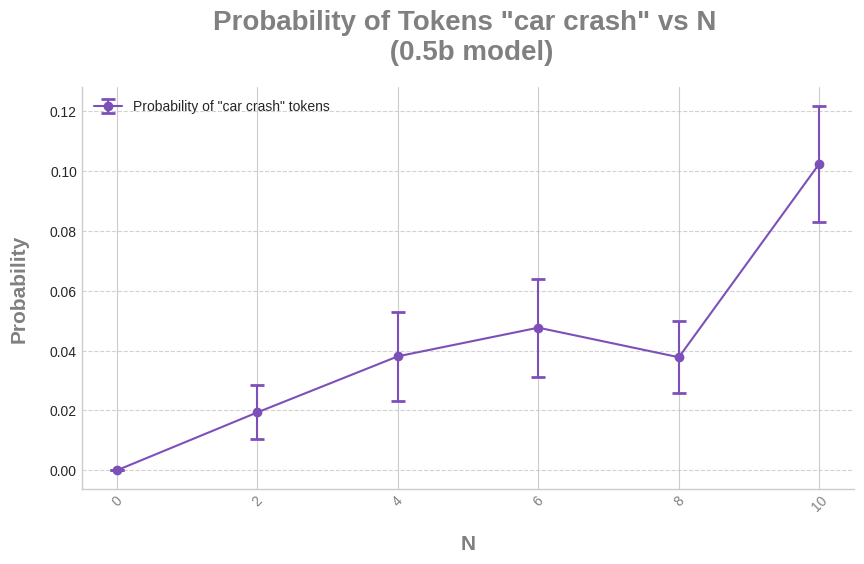

In [ ]:
import matplotlib.pyplot as plt

# Convert RGB to hexadecimal
def rgb_to_hex(rgb):
    return '#{:02x}{:02x}{:02x}'.format(*rgb)

# Define color variables
color_asr_1_L = rgb_to_hex((125, 80, 185))    # From Group 2
color_asr_5_L = rgb_to_hex((15, 165, 215))    # From Group 2
color_asr_1_B = rgb_to_hex((230, 30, 60))     # From Group 5
color_asr_5_B = rgb_to_hex((235, 140, 60))    # From Group 5

gray_50 = rgb_to_hex((128, 128, 128))  # Approximation for C0 M0 Y0 K50
gray_25 = rgb_to_hex((191, 191, 191))  # Approximation for C0 M0 Y0 K25
gray_10 = rgb_to_hex((230, 230, 230))  # Approximation for C0 M0 Y0 K10

# Convert results to sorted lists for plotting
pbs_all[0.0] = 0
errors[0.0] = 0

Ns = sorted(pbs_all.keys())
mean_probs = [pbs_all[N] for N in Ns]
error_bars = [errors[N] for N in Ns]

# Plotting with error bars
plt.figure(figsize=(9, 6))
plt.xticks(rotation=45, color=gray_50)

plt.errorbar(Ns, mean_probs, yerr=error_bars, fmt='o-', capsize=5, capthick=2,
             label=f'Probability of "{class_name}" tokens', color=color_asr_1_L)

# Adding grid with custom color and style
plt.grid(axis='y', linestyle='--', alpha=0.7, color=gray_25)

# Adding title and labels
plt.title(f'Probability of Tokens "{class_name}" vs N \n ({m}b model)', fontsize=20, fontweight='bold', color=gray_50, pad=20)
plt.xlabel('N', fontsize=15, fontweight='bold', color=gray_50, labelpad=15)
plt.ylabel('Probability', fontsize=15, fontweight='bold', color=gray_50, labelpad=15)

# Customize spines
ax = plt.gca()
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

# Adding legend with style
plt.legend(prop={'size': 10}, fancybox=True, framealpha=0.9, edgecolor=gray_50)

# Tight layout for proper spacing
plt.tight_layout(pad=2)

# Show plot
# plt.show()
plt.savefig(f'{class_name}_w_probs_{m}b.pdf')


In [ ]:
pbs_all, errors # f

({10.0: 0.25039630071186675,
  8.0: 0.13229700000000003,
  6.0: 0.04310825,
  4.0: 0.040685,
  2.0: 0.06447449999999999,
  0.0: 0},
 {10.0: 0.03232030535368978,
  8.0: 0.02242445121580459,
  6.0: 0.013484726219771297,
  4.0: 0.01329037756705956,
  2.0: 0.015716261260196398,
  0.0: 0})

In [ ]:
pbs_all, errors # c

({10.0: 0.1473053333333333,
  8.0: 0.10011449999999998,
  6.0: 0.11037287499999998,
  4.0: 0.06319491666666668,
  2.0: 0.037312875},
 {10.0: 0.014164145109297002,
  8.0: 0.013189495567448742,
  6.0: 0.013911842143900168,
  4.0: 0.01066810878089816,
  2.0: 0.008305894127021898})

In [ ]:
pbs_all, errors # cc

({10.0: 0.12280804857621438,
  8.0: 0.06720250000000001,
  6.0: 0.0446860756756757,
  4.0: 0.033858767391653964,
  2.0: 0.02917787328767122},
 {10.0: 0.014890299612073728,
  8.0: 0.012584085259266959,
  6.0: 0.01057941356472348,
  4.0: 0.010031926353952638,
  2.0: 0.008247831101241452})

In [ ]:
pbs_all_c={10.0: 0.15456600000000004,
  8.0: 0.08591049999999999,
  6.0: 0.09636900000000001,
  4.0: 0.07649349999999999,
  2.0: 0.042600500000000006,
  0.0: 0.0}
errors_c=  {10.0: 0.021719638450950325,
  8.0: 0.019169700418825018,
  6.0: 0.01918268081864472,
  4.0: 0.01733856795780724,
  2.0: 0.01319748446665121,
  0.0: 0.0}

In [ ]:
pbs_all_f ={10.0: 0.22231122911051213,
  8.0: 0.1326735,
  6.0: 0.0224925,
  4.0: 0.035433000000000006,
  2.0: 0.062287999999999996}

errors_f = {10.0: 0.03893031189996414,
  8.0: 0.031804606462390014,
  6.0: 0.013231562556535039,
  4.0: 0.017433596132467904,
  2.0: 0.02158810164326637}

In [ ]:
pbs_all_cc = {10.0: 0.10243326666666669,
  8.0: 0.03776975,
  6.0: 0.04764835135135139,
  4.0: 0.03807336820083681,
  2.0: 0.0193565,
  0.0: 0}
errors_cc =  {10.0: 0.019408614217345178,
  8.0: 0.011940236143471995,
  6.0: 0.01637424051596429,
  4.0: 0.01494337698117871,
  2.0: 0.00901211109160889,
  0.0: 0}

In [ ]:
pbs_all_c_1 = {10.0: 0.24001749999999997,
  8.0: 0.17505166666666663,
  6.0: 0.17847900000000003,
  4.0: 0.136742,
  2.0: 0.162210101010101,
    0.0:0}
errors_c_1 =  {10.0: 0.03378915355831662,
  8.0: 0.030346740034969157,
  6.0: 0.0317692867104378,
  4.0: 0.0259344267116125,
  2.0: 0.03119418851635767,
    0.0:0}

[2.0, 4.0, 6.0, 8.0, 10.0]
[0.2, 0.4, 0.6, 0.8, 1.0]


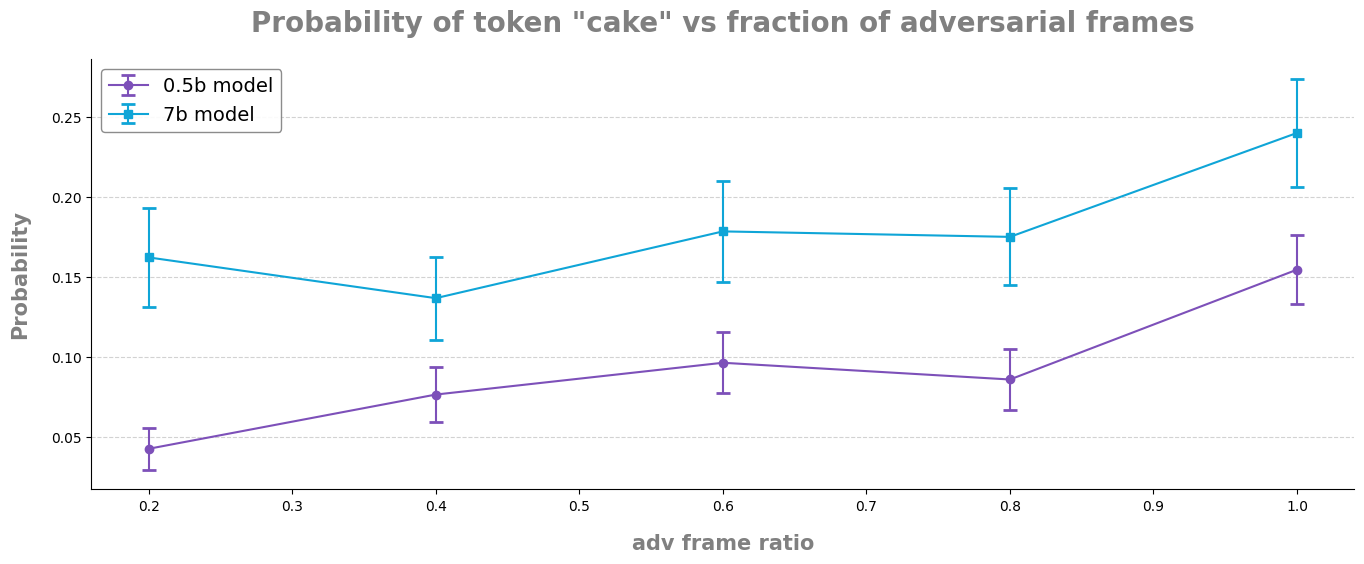

In [ ]:
import matplotlib.pyplot as plt

# Convert RGB to hexadecimal
def rgb_to_hex(rgb):
    return '#{:02x}{:02x}{:02x}'.format(*rgb)

# Define color variables for multiple lines
color_asr_1_L = rgb_to_hex((125, 80, 185))    # Line 1 color
color_asr_5_L = rgb_to_hex((15, 165, 215))    # Line 2 color
color_asr_1_B = rgb_to_hex((230, 30, 60))     # Line 3 color
color_asr_5_B = rgb_to_hex((235, 140, 60))    # Line 4 color

gray_50 = rgb_to_hex((128, 128, 128))  # Gray for text
gray_25 = rgb_to_hex((191, 191, 191))  # Lighter gray for grid
gray_10 = rgb_to_hex((230, 230, 230))  # Lightest gray for background

fig, ax = plt.subplots(1, 1, figsize=(14, 6))
ax = [ax, ax]
# Example data for plotting multiple lines
Ns = sorted(pbs_all_c.keys())[1:]
print(Ns)
mean_probs_1 = [pbs_all_c[N] for N in Ns]  # Data for the first line
mean_probs_11 = [pbs_all_c_1[N] for N in Ns]  # Data for the first line
mean_probs_2 = [pbs_all_f[N] for N in Ns]  # Data for the first line
mean_probs_3 = [pbs_all_cc[N] for N in Ns]  # Data for the first line

errors_c_ = [errors_c[N] for N in Ns]
errors_c_1_ = [errors_c_1[N] for N in Ns]

errors_f_ = [errors_f[N] for N in Ns]
errors_cc_ = [errors_cc[N] for N in Ns]

# Plotting multiple lines with error bars
# plt.xticks(rotation=45, color=gray_50)

# Line 1
Ns_ = list(map(lambda x: x / 10, sorted(pbs_all_c.keys())[1:]))
print(Ns_)
# ax[0].errorbar(Ns_, mean_probs_1, yerr=errors_c_, fmt='o-', capsize=5, capthick=2,
            #  label='Probability of token "cake"', color=color_asr_1_L)
ax[1].errorbar(Ns_, mean_probs_1, yerr=errors_c_, fmt='o-', capsize=5, capthick=2,
             label='0.5b model', color=color_asr_1_L)
# Line 2
# ax[0].errorbar(Ns_, mean_probs_2, yerr=errors_f_, fmt='s-', capsize=5, capthick=2,
            #  label='Probability of token "f*ck"', color=color_asr_5_L)
ax[1].errorbar(Ns_, mean_probs_11, yerr=errors_c_1_, fmt='s-', capsize=5, capthick=2,
             label='7b model', color=color_asr_5_L)

# # Line 3
# ax[0].errorbar(Ns_, mean_probs_3, yerr=errors_cc_, fmt='^-', capsize=5, capthick=2,
            #  label='Probability of tokens "car crash"', color=color_asr_1_B)


# Adding grid with custom color and style
# ax[0].grid(axis='y', linestyle='--', alpha=0.7, color=gray_25)
ax[1].grid(axis='y', linestyle='--', alpha=0.7, color=gray_25)

# Adding title and labels
# ax[0].set_title('Probability of different tokens vs fraction of adversarial frames', fontsize=20, fontweight='bold', color=gray_50, pad=20)
ax[1].set_title('Probability of token "cake" vs fraction of adversarial frames', fontsize=20, fontweight='bold', color=gray_50, pad=20)

ax[1].set_xlabel('adv frame ratio', fontsize=15, fontweight='bold', color=gray_50, labelpad=15)
# ax[0].set_xlabel('adv frame ratio', fontsize=15, fontweight='bold', color=gray_50, labelpad=15)

# ax[0].set_xlabel('N', fontsize=15, fontweight='bold', color=gray_50, labelpad=15)
# ax[0].set_ylabel('Probability', fontsize=15, fontweight='bold', color=gray_50, labelpad=15)
ax[1].set_ylabel('Probability', fontsize=15, fontweight='bold', color=gray_50, labelpad=15)

# Customize spines
# ax_ = plt.gca()
for spine in ['top', 'right']:
    # ax[0].spines[spine].set_visible(False)
    ax[1].spines[spine].set_visible(False)

# Adding legend with style
# ax[0].legend(prop={'size': 14}, fancybox=True, framealpha=0.9, edgecolor=gray_50)
ax[1].legend(prop={'size': 14}, fancybox=True, framealpha=0.9, edgecolor=gray_50)

# Tight layout for proper spacing
plt.tight_layout(pad=2)

# Show plot
# plt.show()
m=7
plt.savefig(f"all_{m}b_2.pdf")


In [ ]:
pbs_all

{10.0: 0.1473053333333333,
 9.0: 0.12198250000000002,
 8.0: 0.10011449999999998,
 7.0: 0.09364375000000004,
 6.0: 0.11037287499999998,
 5.0: 0.06063891666666666,
 4.0: 0.06319491666666668,
 3.0: 0.06695224999999999,
 2.0: 0.037312875,
 1.0: 0.02475533333333333}

In [ ]:
import matplotlib.pyplot as plt

plt.plot(sorted(pbs_all.values(), key=lambda )


SyntaxError: invalid syntax (<ipython-input-6-3780faeab6ed>, line 3)

In [ ]:
import json



save_ans_path
# Открываем JSON-файл
with open('data.json') as f:
    data = json.load(f)